In [10]:
import plumed
import matplotlib.pyplot as plt
import os
import MDAnalysis
import mdtraj as md 
import numpy as np
import math
import pyemma
from os import getcwd as wd
from os import chdir as cd
import pandas as pd
from IPython.display import Image
import seaborn as sns
def extract_files(dr,root,n,end):
    l=[]
    if dr == None:
        dr = os.getcwd()
    if end == None:
        targets = [dr+"/"+str(root)+"{}".format(str(j)) for j in range(n)]
    else:
        targets = [dr+"/"+str(root)+"{}".format(str(j))+end for j in range(n)]
        
    for i in targets:
            for k in [dr+"/"+f for f in os.listdir(dr) if os.path.isfile(os.path.join(dr,f))]:
                if i == k: l.append(i)
    return l   

def plotmed(cv):
   
    df = [plumed.read_as_pandas(i) for i in cv]
    arr = [i.to_numpy() for i in df]
    cat = np.concatenate(arr,axis=0)
    cat[~np.isfinite(cat)] = 0
    title = df[0].columns.tolist()
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    pyemma.plots.plot_free_energy(*cat[:,1:3].T,ax=ax)
    ax.set_xlabel("{}".format(title[1]))
    ax.set_ylabel("{}".format(title[2]))
    ax.set_title("S tells you where you are in the path, Z tells you how far away you are from the nearest guess frame")
    
    if len(cv)>=5:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
        pyemma.plots.plot_free_energy(*cat[:,3:5].T,ax=ax)
        ax.set_xlabel("{}".format(title[3]))
        ax.set_ylabel("{}".format(title[4]))
   
    for i,t in enumerate(title):
        plt.figure()
        for j in df:
            j.iloc[:,i].plot(xlabel="Time",ylabel=t)
           
    fig,ax=plt.subplots(len(title),1, figsize=(8,2.5*len(title)))
    for i,(t,ax) in enumerate(zip(title,ax.flat)):
        sns.kdeplot(cat[:,i],ax=ax)
        ax.set_xlabel(f"{t}")
        plt.tight_layout()
   
    return df,arr,cat



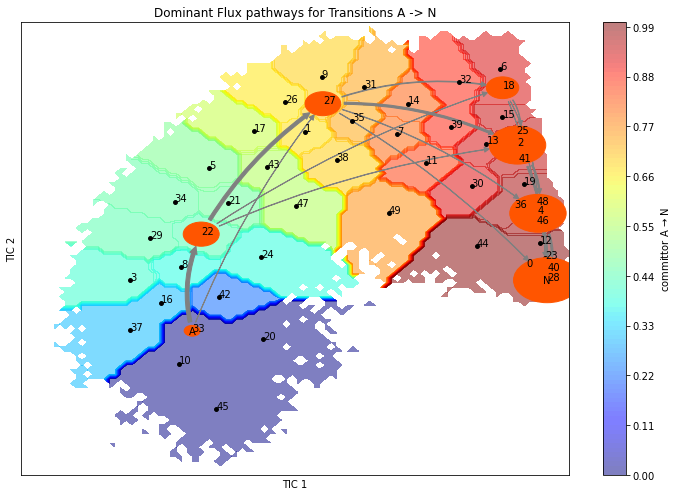

In [7]:
Image(filename="/home/t/IDP_MSM/NtailXD_Data/flux.png")

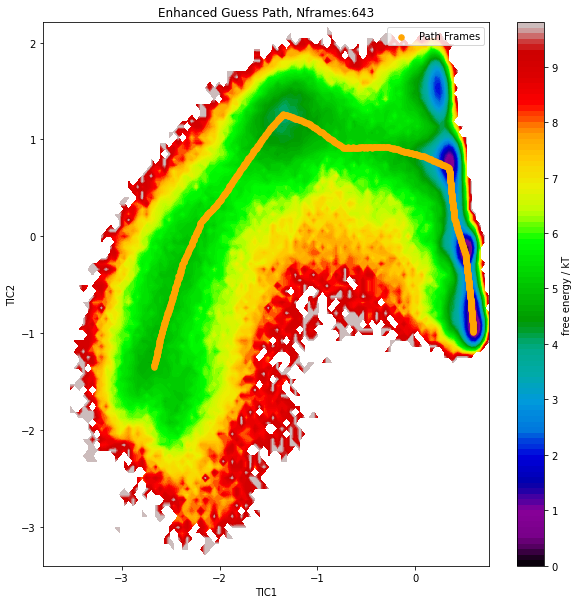

In [9]:
Image(filename="/home/t/IDP_MSM/NtailXD_Data/index.png")

In [11]:
wd = os.getcwd()+"/"

Text(0.5, 1.0, 'Distribution of CV Z - TICA space, Tells you how far away from the path you are')

<Figure size 432x288 with 0 Axes>

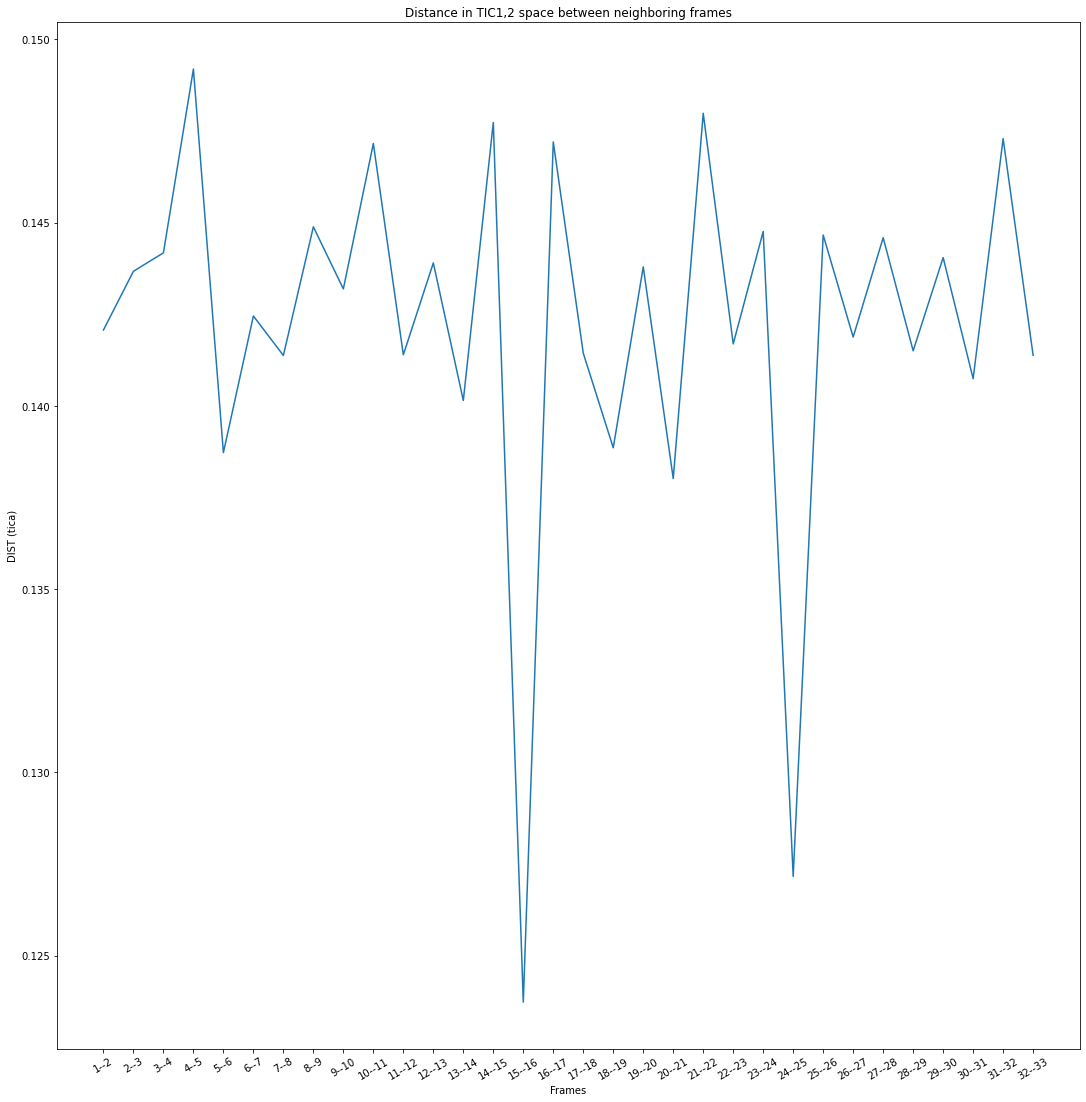

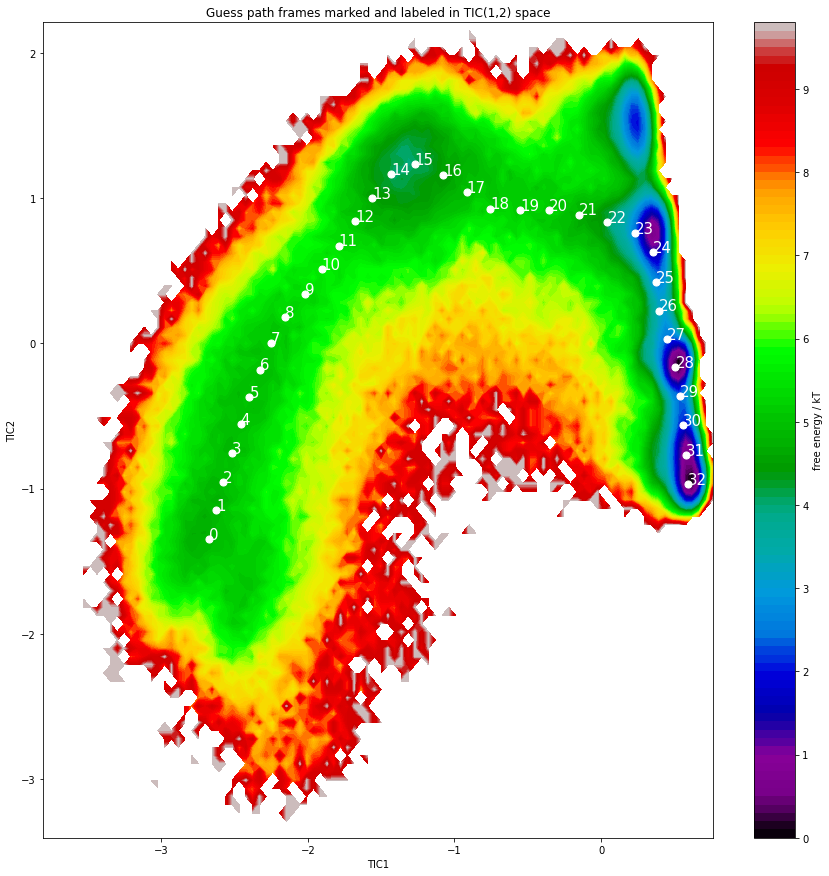

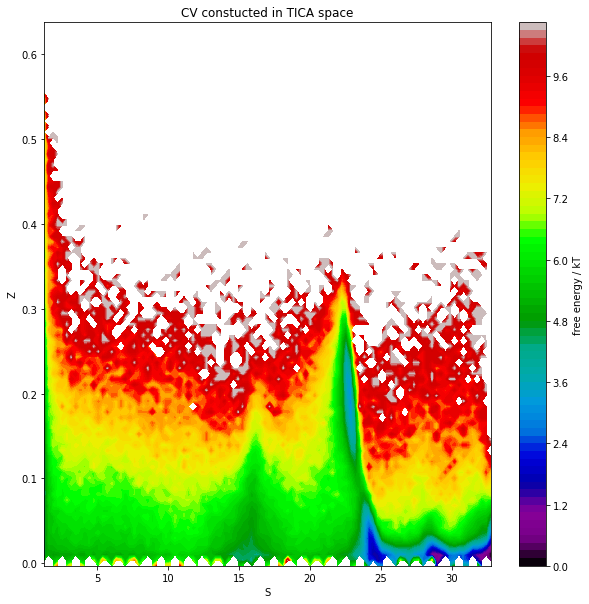

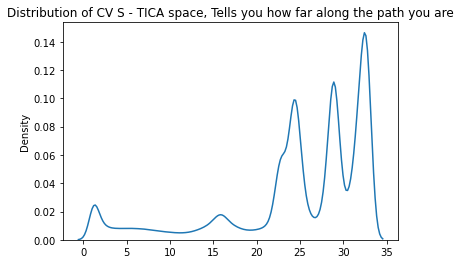

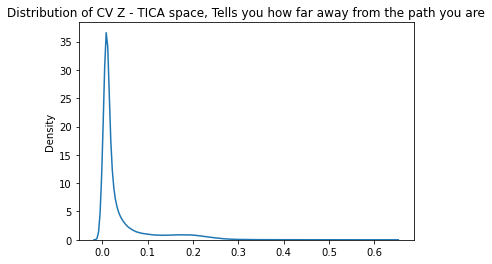

In [12]:
"""now we want to make a PCV of the ntail.xd simulation at 400K

If we want to make a PCV that makes sense in the context of the free energy surface created
by a dimensionality reduction method or a set of raw features, we must create PCVs that live
in the space of that data. This includes features like RMSD"""



"""Here I define the plumed functions from the documentation to calculate PCV's S and Z
***PVC's S and Z and introduced and defined in the backround notebook***


"""

#define plumed functions
def rmsd(x1,x2):
    if len(x1)==len(x2):
        return np.sqrt(np.sum((x1-x2)**2)/len(x1))
        
def lam(xi):
    num = 2.3*(len(xi)-1)
    denom = 0
    for i in range(len(xi)-1):
        denom += rmsd(xi[i],xi[i+1])
    return num/denom
        
def S(x,xi,lam):
    return np.sum(np.array([(j+1)*np.exp(-lam*rmsd(x,i)) for j,i in enumerate(xi)]))/np.sum(
        np.array([np.exp(-lam*rmsd(x,i)) for i in xi]))

def Z(x,xi,lam):
    return (-1/lam)*np.log10(np.sum(np.array([np.exp(-lam*rmsd(x,i)) for i in xi])))


#Here I'm going to construct a path in TICA space and use the values of tic 1 and 2 as inputs to CONSTRUCT the
# actual path collective variables, S and Z

p = np.load(wd+"ntxd/dist_sa_tics_lag30.npy")
path_frames = np.load(wd+"ntxd/enhanced_path_frames.npy")
path_frames = path_frames[::20]
p_red = p[:,:2]
plt.figure()
tica_displacements = []
for i in range(len(path_frames)-1):
    tica_displacements.append(rmsd(p_red[path_frames[i]],p_red[path_frames[i+1]]))

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.arange(1,len(tica_displacements)+1),tica_displacements)
ax.set_xticks(np.arange(1,1+len(tica_displacements)),[f"{i+1}--{i+2}" for i in range(len(tica_displacements))],rotation =30)
plt.tight_layout()
ax.set_title("Distance in TIC1,2 space between neighboring frames")
ax.set_ylabel("DIST (tica)")
ax.set_xlabel("Frames")



fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[path_frames].T,c="white",s=50)
for j,c in enumerate(path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="white")
ax.set_xlabel("TIC1")
ax.set_ylabel("TIC2")
ax.set_title("Guess path frames marked and labeled in TIC(1,2) space")

xi = [p_red[i] for i in path_frames]
lam_ = lam(xi)
pathS = [S(x,xi,lam_) for x in p_red]
pathZ = [Z(x,xi,lam_) for x in p_red]

fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(pathS,pathZ,ax=ax)
ax.set_xlabel("S")
ax.set_ylabel("Z")
ax.set_title("CV constucted in TICA space")
plt.figure()
sns.kdeplot(pathS)
plt.title("Distribution of CV S - TICA space, Tells you how far along the path you are")

plt.figure()
sns.kdeplot(pathZ)
plt.title("Distribution of CV Z - TICA space, Tells you how far away from the path you are")

##we see that the S CV has a distribution that represents each of our clusters in the path.

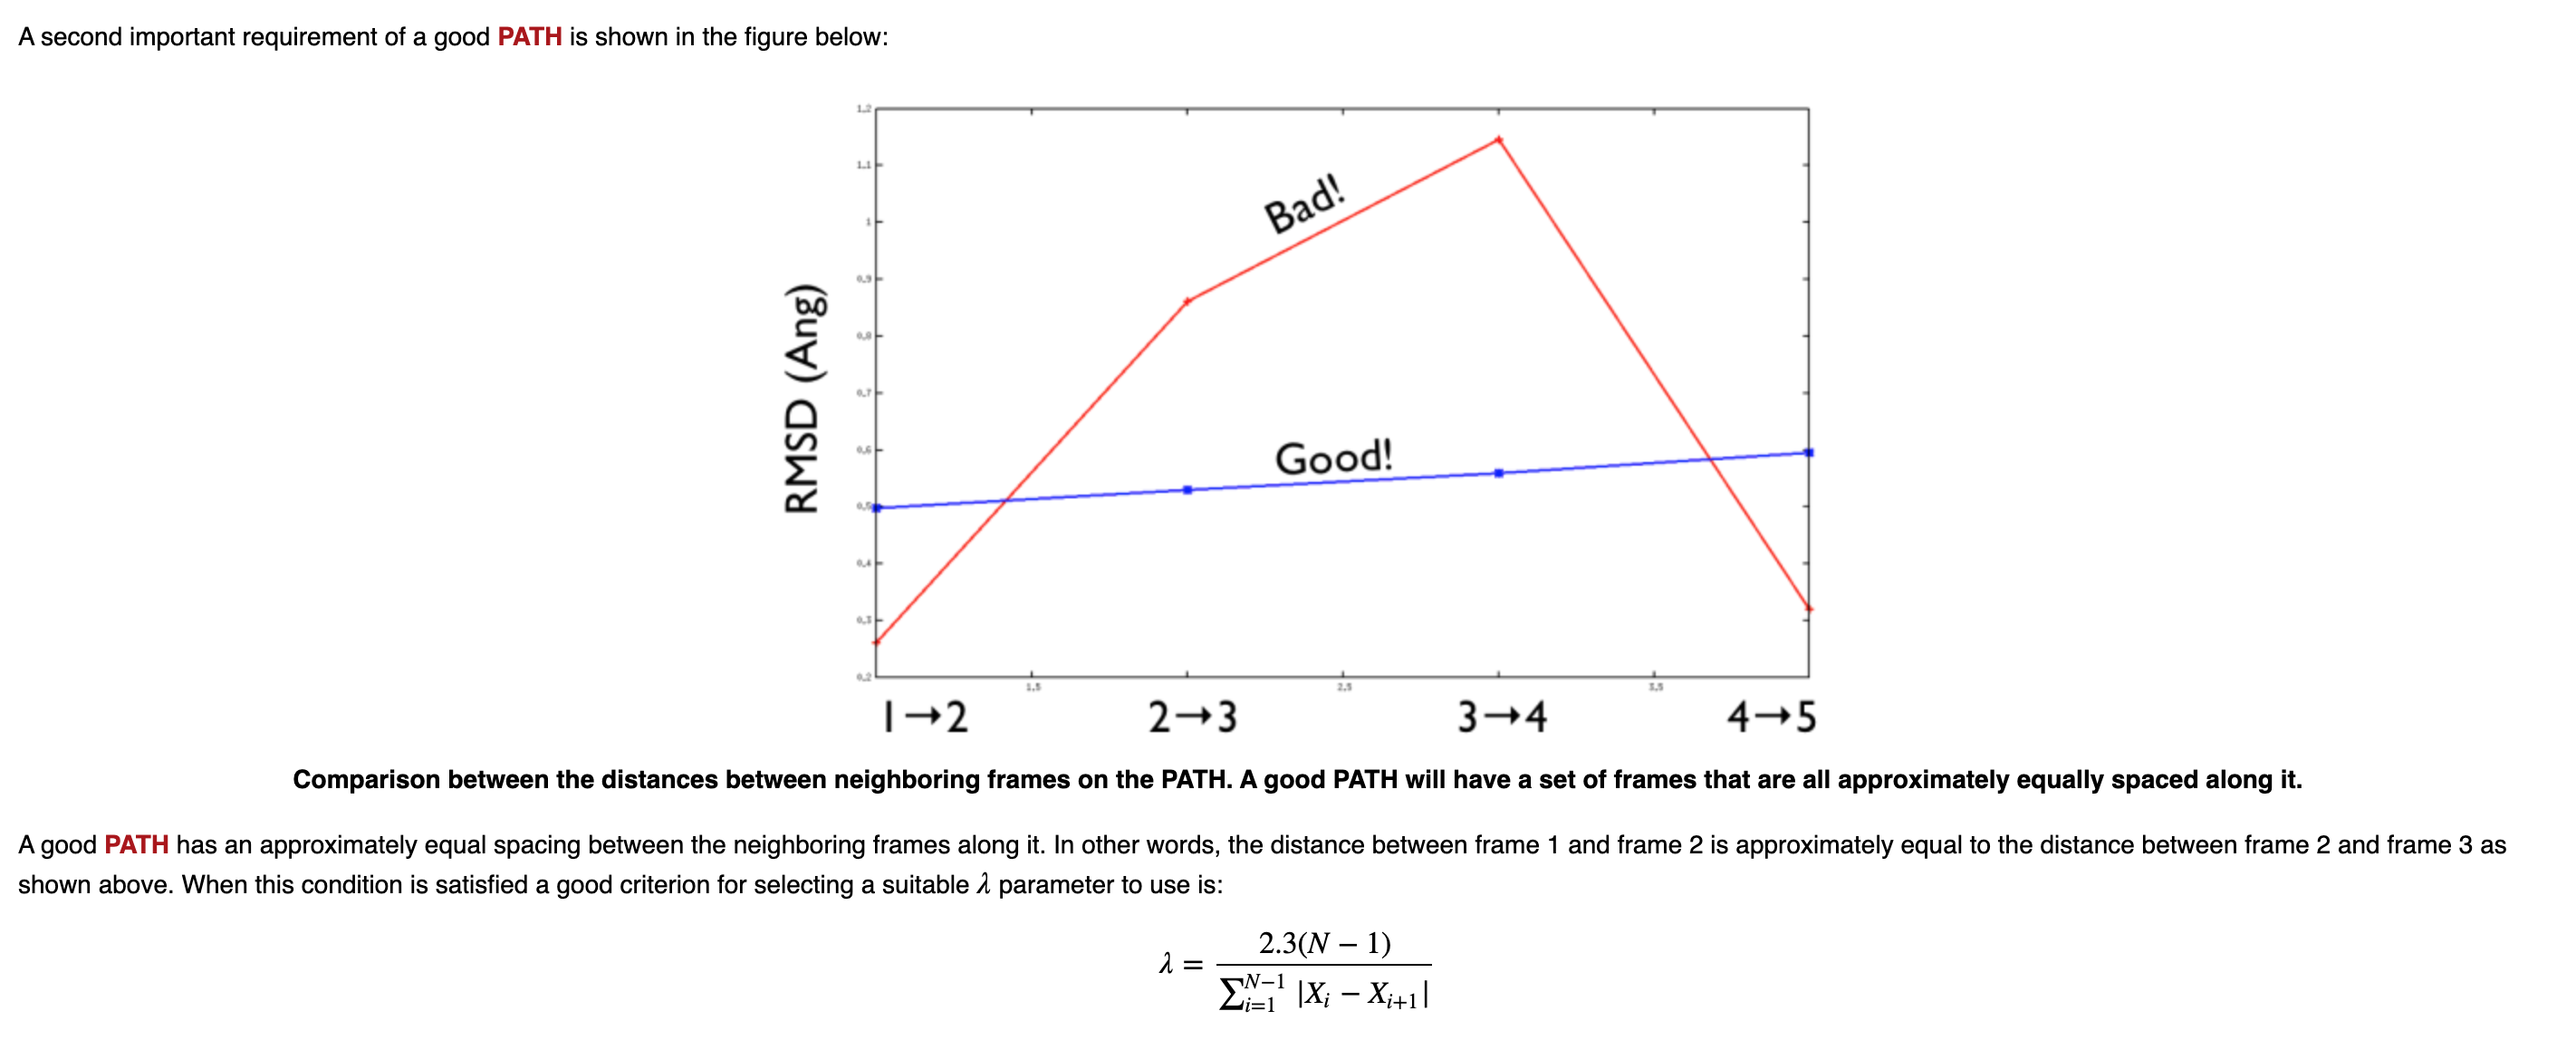

In [50]:
"""We now move onto calcululating the PCV's S and Z using the rmsd between each frame of our guess path and the 
instantaneous frame of the simulation

Before calculating S and Z we need to calculate the rmsd between the ith and i + 1 frame of our guess path
in order to calculate the lambda parameter used in both S and Z"""

Image(filename="/home/t/Downloads/Screen Shot 2022-03-14 at 8.46.31 PM.png")

In [14]:
trj = md.load(wd+"ntxd/enhanced_path_frames.pdb")
trj.center_coordinates()
trj = trj[::20]
rmsds = []
for i in range(len(trj)-1):
    r = md.rmsd(trj[i],trj[i+1])
    rmsds.append(r)

LAMBDA:2.278458497469614


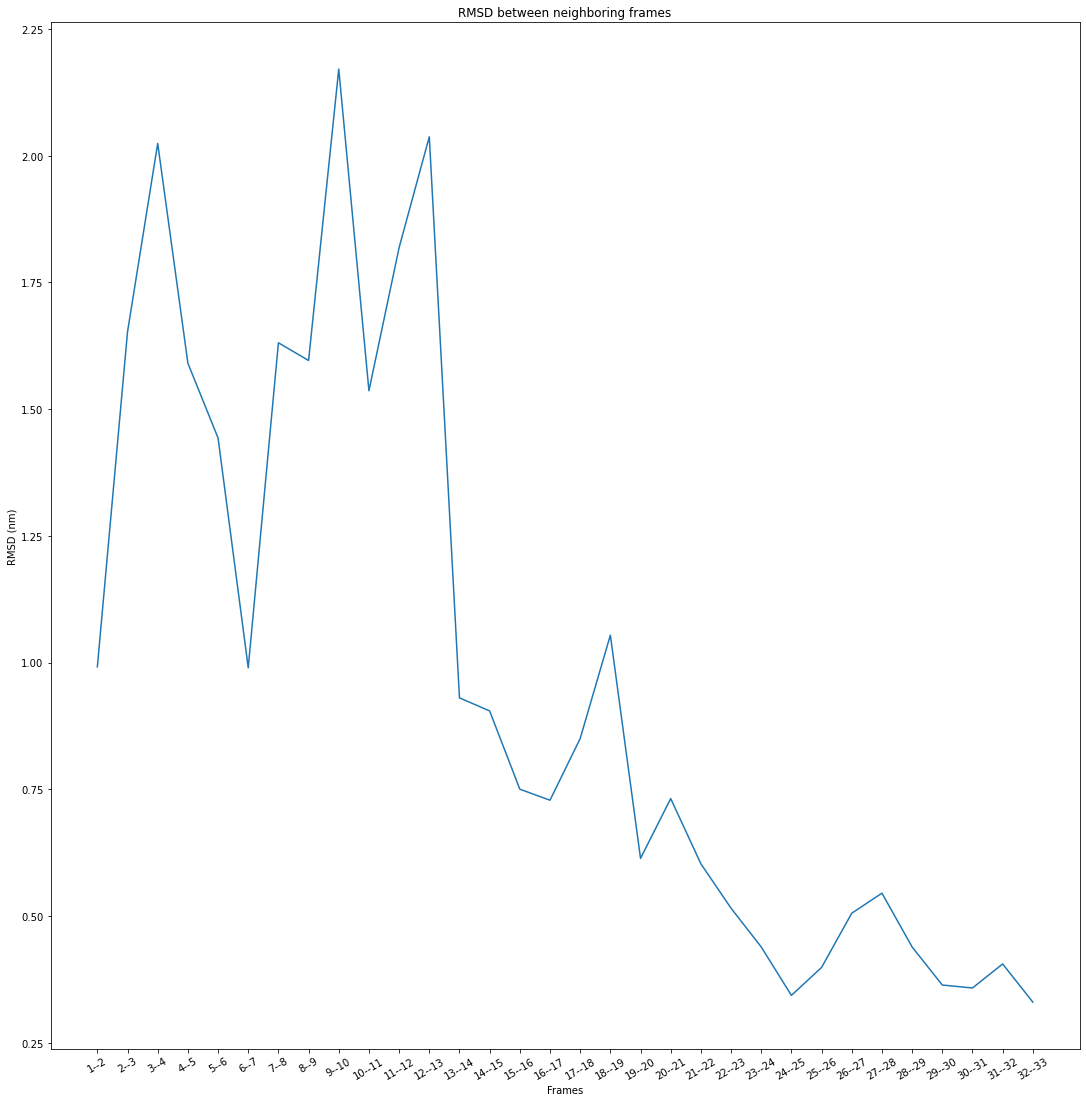

In [16]:
"""This plots tells us that our guess path frames are not evenly spaced in rmsd space
However, we know these frames are significant in our folding pathway. So, we calculate anyway.
Ideally, we want this plot to look like the above figure,
the folding pathway determined from the MSM is not well decribed with the rmsd metric"""

fig,ax = plt.subplots(1,1,figsize = (15,15))
ax.plot(np.arange(1,len(rmsds)+1),rmsds)
ax.set_xticks(np.arange(1,1+len(rmsds)),[f"{i+1}--{i+2}" for i in range(len(rmsds))],rotation =30)
plt.tight_layout()
ax.set_title("RMSD between neighboring frames")
ax.set_ylabel("RMSD (nm)")
ax.set_xlabel("Frames")

lam_rmsd = (2.3*(len(rmsds)-1))/np.sum(np.array(rmsds))
print(f"LAMBDA:{lam_rmsd}")

In [17]:
lam_

16.172974306382798

In [18]:
%%bash
#lets do the same thing, except this time we use the rmsd between the instantaneous frame 
#and each frame in our guess path as the input to constuct the PCVs S and Z

#let's try the lambda value we got from the TIC S,Z
cd ./ntxd
# create PLUMED input file
rm -rf colvar_path_rmsd_final_enhanced

cat > "plumed.dat" << EOF
# Activate MOLINFO functionalities
#MOLINFO STRUCTURE=../../data/diala/dialaA.pdb

path: PATH REFERENCE=./enhanced_path_frames.pdb TYPE=OPTIMAL LAMBDA=16.1729743063

PRINT ARG=path.spath,path.zpath STRIDE=50 FILE=colvar_path_rmsd_final_enhanced FMT=%12.8f
EOF

plumed driver --plumed plumed.dat --mf_pdb ./trunc_traj.pdb




DRIVER: Found molfile format trajectory pdb with name ./trunc_traj.pdb
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.0 (git: Unknown) compiled on Feb 23 2022 at 09:52:46
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/t/anaconda3/envs/plumed/lib/plumed
PLUMED: For installed feature, see /home/t/anaconda3/envs/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1138
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action PATH
PLUMED:   with label path
PLUMED:   found 643 configurations in file ./enhanced_path_frames.pdb
PLUMED:   found 1138 atoms in input 
PLUMED:   with indices : 
PLUMED: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
PLUMED: 26 27 28 29 30 31 32 33 34 35 36 37 38

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/t/anaconda3/envs/plumed/lib/libplumedKernel.so" +++


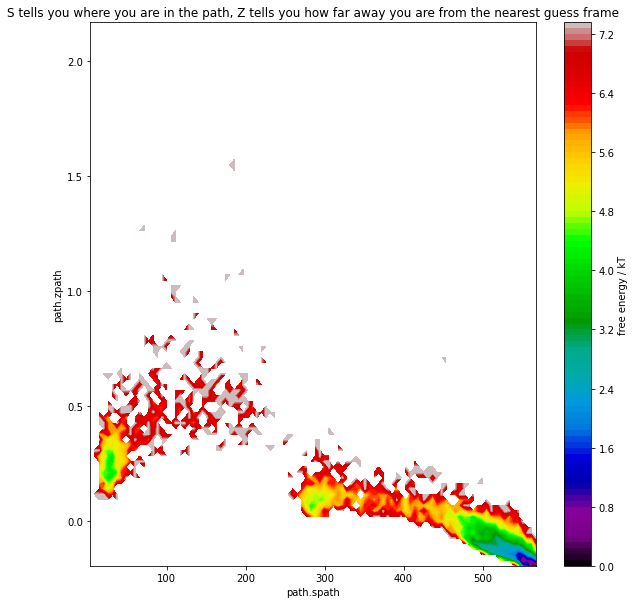

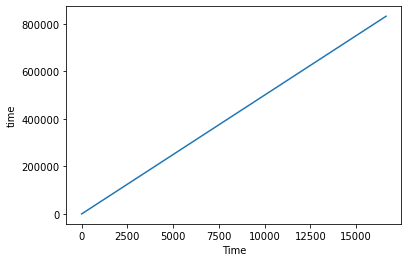

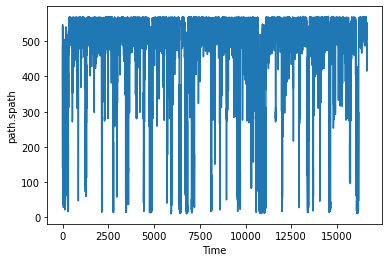

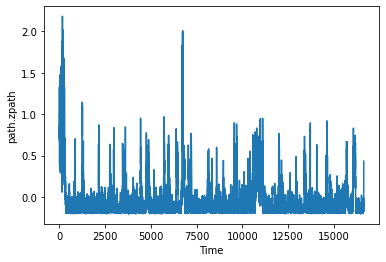

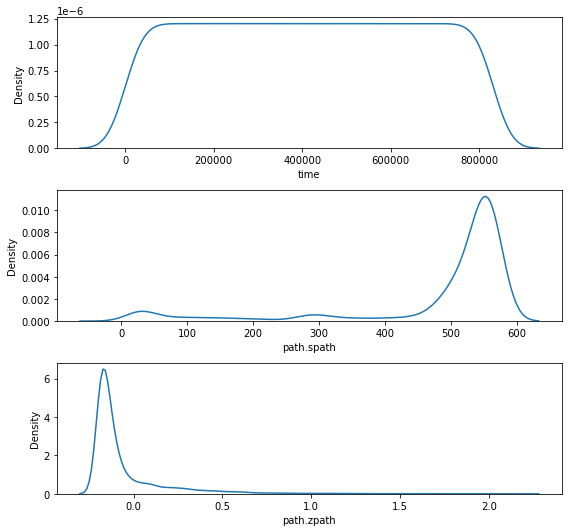

In [19]:
#the CV Z can be negative i.e "above"  or "below" path based on feature space
##the CV does not effectivly differentiate between different states

#Visualize CV S and Z

_,_,_=plotmed([wd+"ntxd/colvar_path_rmsd_final_enhanced"])

In [58]:
!find $(pwd) | grep colvar_path_rmsd_short_final

/home/t/chem101/pcv/marvel-2/ntxd/colvar_path_rmsd_short_final


Text(0.5, 0, 'Z')

<Figure size 432x288 with 0 Axes>

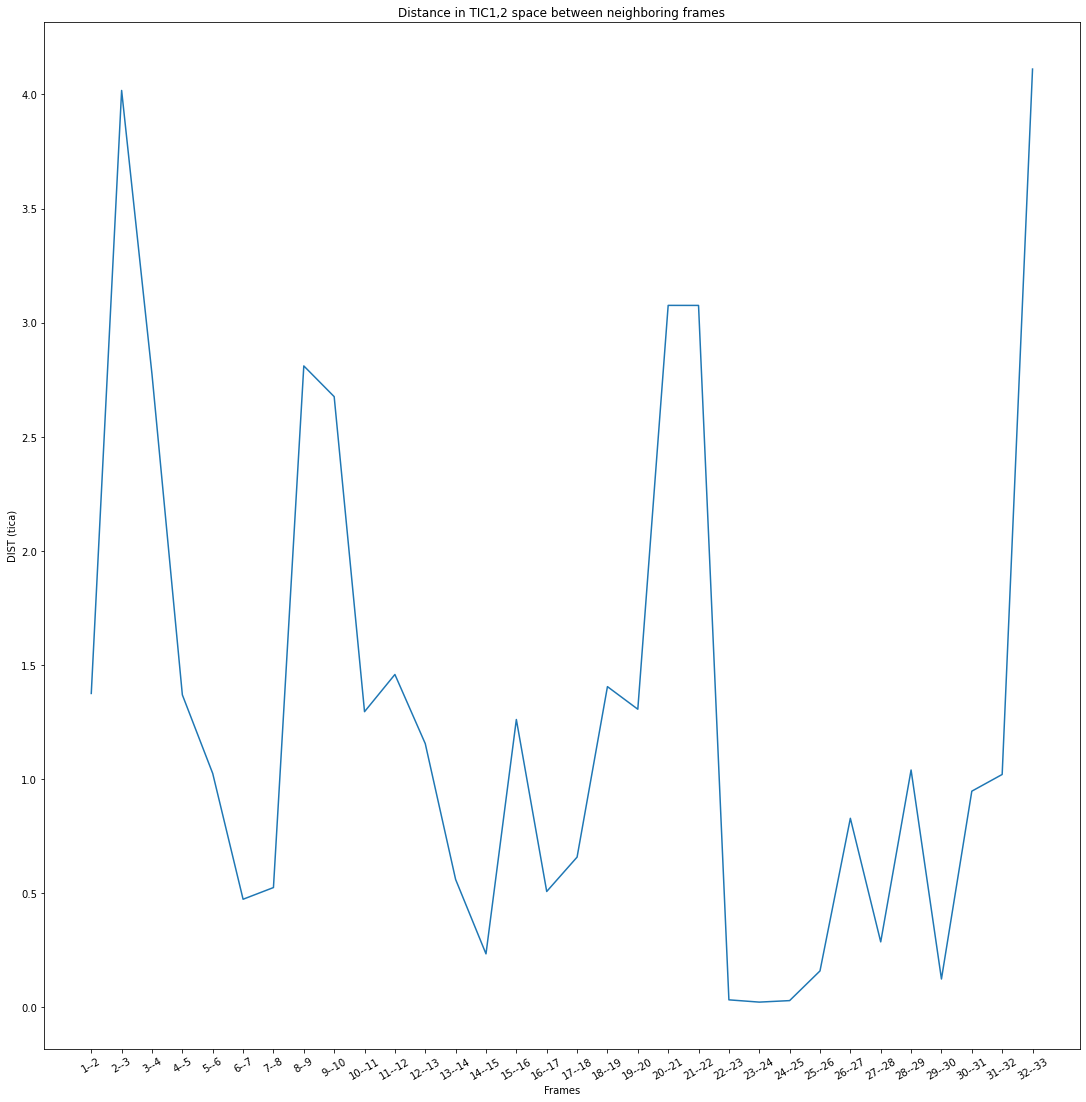

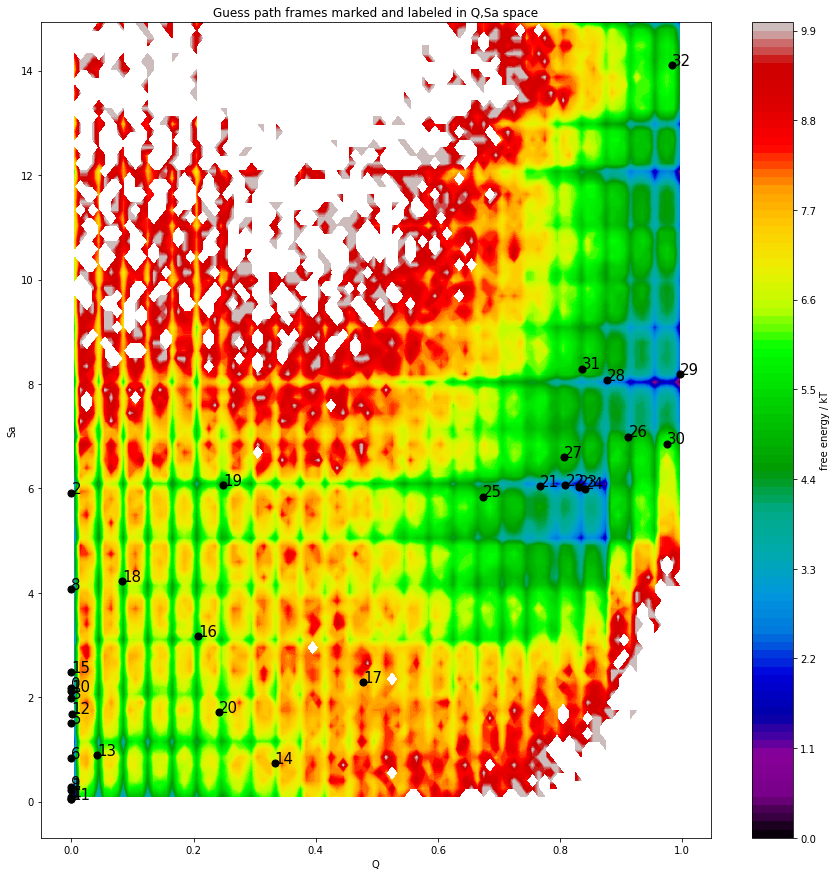

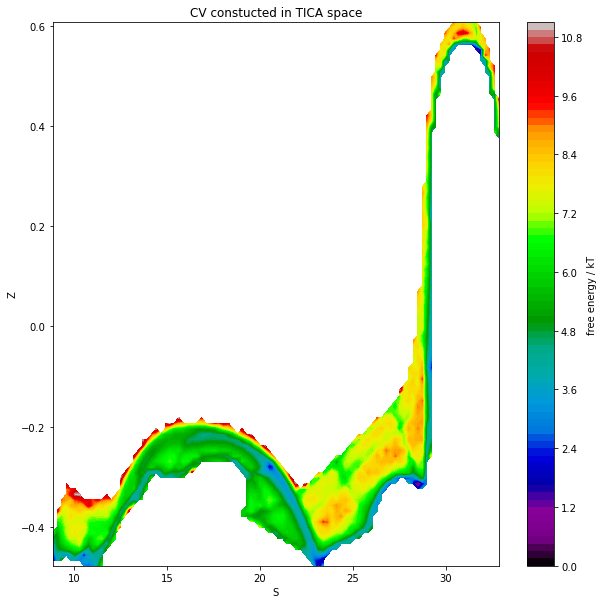

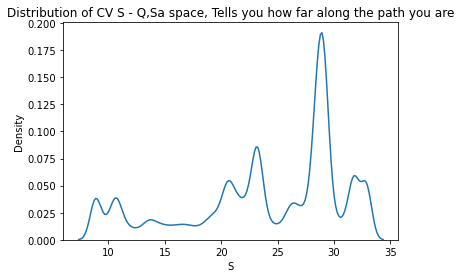

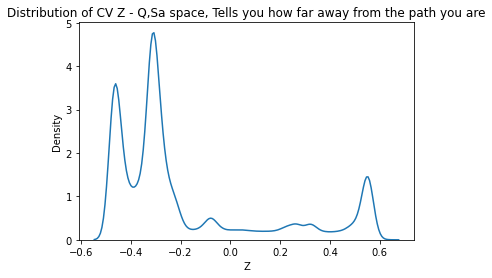

In [20]:
#let's try calculating  S and Z in the space of Sa and Q
Q = np.load(wd+"ntxd/QP_trunc.npy")
Sa = np.load(wd+"ntxd/Sa_total_trunc.npy")
p = np.stack([Q,Sa],axis=1)
p_red = p

plt.figure()
tica_displacements = []
for i in range(len(path_frames)-1):
    tica_displacements.append(rmsd(p_red[path_frames[i]],p_red[path_frames[i+1]]))

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.arange(1,len(tica_displacements)+1),tica_displacements)
ax.set_xticks(np.arange(1,1+len(tica_displacements)),[f"{i+1}--{i+2}" for i in range(len(tica_displacements))],rotation =30)
plt.tight_layout()
ax.set_title("Distance in TIC1,2 space between neighboring frames")
ax.set_ylabel("DIST (tica)")
ax.set_xlabel("Frames")



fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[path_frames].T,c="black",s=50)
for j,c in enumerate(path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="black")
ax.set_xlabel("Q")
ax.set_ylabel("Sa")
ax.set_title("Guess path frames marked and labeled in Q,Sa space")

xi = [p_red[i] for i in path_frames]
lam_ = lam(xi)
pathS = [S(x,xi,lam_) for x in p_red]
pathZ = [Z(x,xi,lam_) for x in p_red]

fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(pathS,pathZ,ax=ax)
ax.set_xlabel("S")
ax.set_ylabel("Z")
ax.set_title("CV constucted in TICA space")
plt.figure()
sns.kdeplot(pathS)
plt.title("Distribution of CV S - Q,Sa space, Tells you how far along the path you are")
plt.xlabel("S")

plt.figure()
sns.kdeplot(pathZ)
plt.title("Distribution of CV Z - Q,Sa space, Tells you how far away from the path you are")
plt.xlabel("Z")

##we see that the S CV has a distribution that represents each of our clusters in the path.

Text(0.5, 0, 'Z')

<Figure size 432x288 with 0 Axes>

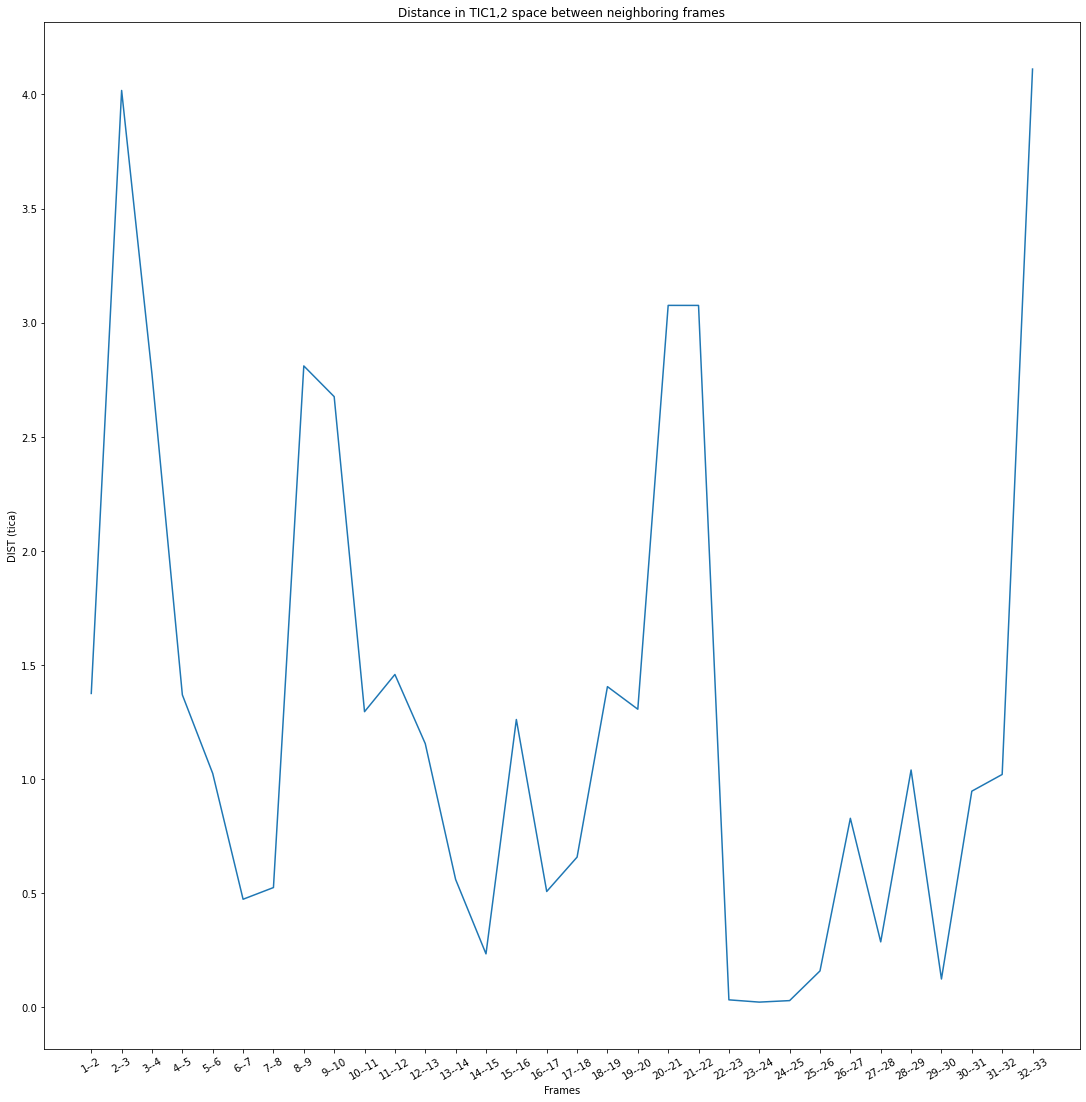

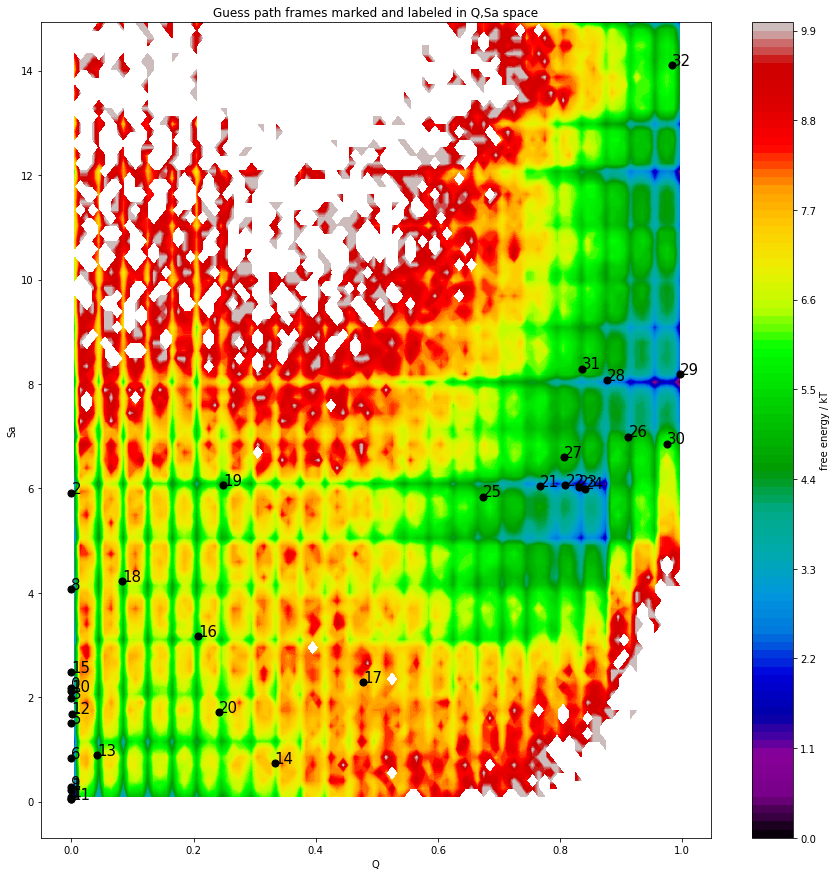

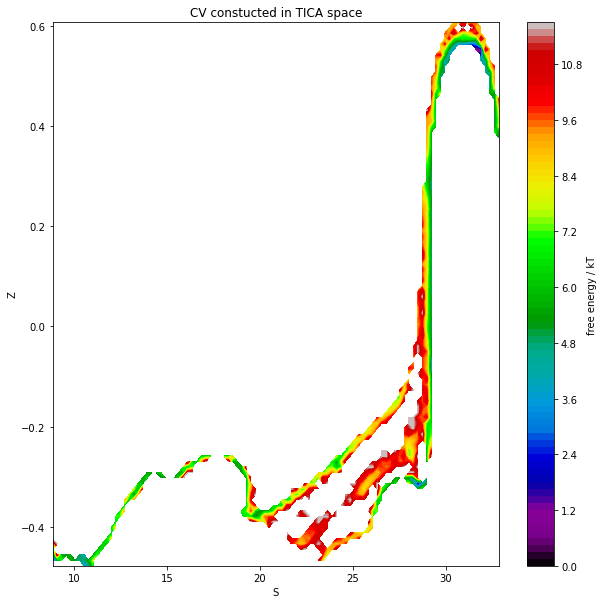

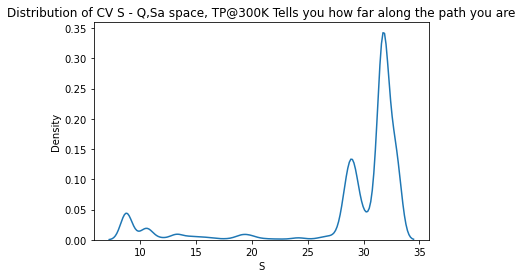

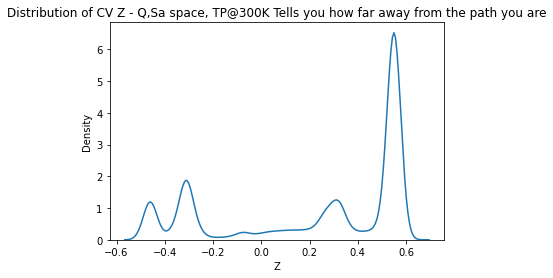

In [21]:
##lets calculate S and Z using the same path using  for one of our transition path trajectories 
##at 300K as the instantaneous feature set


Q_tp = np.load(wd+"ntxd/Qarr_para1.npy")
Sa_tp = np.load(wd+"ntxd/SAarr_para1.npy")
inp = np.stack([Q_tp,np.sum(Sa_tp,axis=1)],axis=1)

plt.figure()
tica_displacements = []
for i in range(len(path_frames)-1):
    tica_displacements.append(rmsd(p_red[path_frames[i]],p_red[path_frames[i+1]]))

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.arange(1,len(tica_displacements)+1),tica_displacements)
ax.set_xticks(np.arange(1,1+len(tica_displacements)),[f"{i+1}--{i+2}" for i in range(len(tica_displacements))],rotation =30)
plt.tight_layout()
ax.set_title("Distance in TIC1,2 space between neighboring frames")
ax.set_ylabel("DIST (tica)")
ax.set_xlabel("Frames")



fig,ax = plt.subplots(1,1,figsize=(15,15))
pyemma.plots.plot_free_energy(*p_red.T,ax=ax)
ax.scatter(*p_red[path_frames].T,c="black",s=50)
for j,c in enumerate(path_frames):
    ax.annotate(text=f"{j}",xy=(p_red[c]),size=15,color="black")
ax.set_xlabel("Q")
ax.set_ylabel("Sa")
ax.set_title("Guess path frames marked and labeled in Q,Sa space")

# xi = [p_red[i] for i in path_frames]
# lam_ = lam(xi)
pathS = [S(x,xi,lam_) for x in inp]
pathZ = [Z(x,xi,lam_) for x in inp]

fig,ax = plt.subplots(1,1,figsize=(10,10))
pyemma.plots.plot_free_energy(pathS,pathZ,ax=ax)
ax.set_xlabel("S")
ax.set_ylabel("Z")
ax.set_title("CV constucted in TICA space")
plt.figure()
sns.kdeplot(pathS)
plt.title("Distribution of CV S - Q,Sa space, TP@300K Tells you how far along the path you are")
plt.xlabel("S")

plt.figure()
sns.kdeplot(pathZ)
plt.title("Distribution of CV Z - Q,Sa space, TP@300K Tells you how far away from the path you are")
plt.xlabel("Z")